In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, SpatialDropout2D, BatchNormalization, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline  

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
labels = os.listdir('/content/drive/My Drive/natural_images')
print(labels)

['car', 'cat', 'airplane', 'flower', 'dog', 'person', 'fruit', 'motorbike']


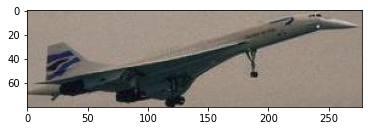

In [4]:
DATADIR = '/content/drive/My Drive/natural_images'
CATEGORIES = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

for category in CATEGORIES:
   path = os.path.join(DATADIR, category)    # takes us to the directory where labels are located
   for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
      plt.imshow(img_array)
      plt.show()
      break
   break

In [5]:
img_array.shape

(80, 278, 3)

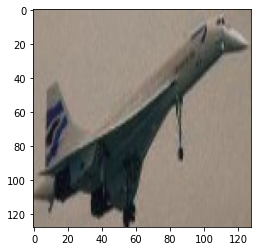

In [6]:
IMG_SIZE = 128

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resizing the images
plt.imshow(new_array)
plt.show()

In [7]:
new_array.shape

(128, 128, 3)

To check whether gpu is working or not.

In [9]:

tf.test.gpu_device_name()

'/device:GPU:0'

Now, the above steps are combined into a function, so that every image can get converted to (128, 128, 3) shape

(128,128,3) --> (height, width, number of channels i.e. RGB)



In [10]:
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)    # takes us to the directory where labels are located
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resizing the images
                train_data.append([new_array, class_num])
                
            except Exception as e:
                pass
            
create_train_data()

In [11]:
print(len(train_data))

7146


In [13]:
import random
random.shuffle(train_data)   # shuffle the train-data

In [14]:
for sample in train_data[:5]:           # to check the labels
    print(sample[1])

5
6
3
5
6


In [15]:
X = []        # for features
Y = []        # for labels

In [16]:
for features, labels in train_data:
    X.append(features)
    Y.append(labels)
    
X = np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)

In [17]:
X.shape

(7146, 128, 128, 3)

In [18]:
le = LabelEncoder()

In [19]:
Y = le.fit_transform(Y)
Y = keras.utils.to_categorical(Y, num_classes = 8)            # Y is converted to one hot category by using to_categorical method 
y = np.array(Y)

In [20]:
y.shape

(7146, 8)

In [21]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
X = X / 255       # for normalizing

Splitting of the given image data 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4644, 128, 128, 3), (2502, 128, 128, 3), (4644, 8), (2502, 8))

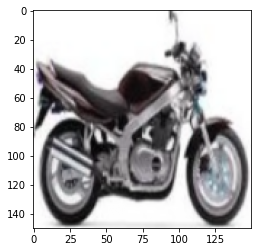

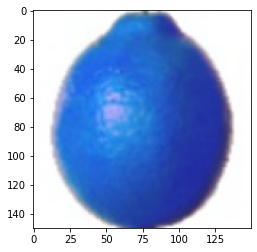

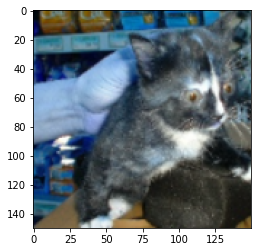

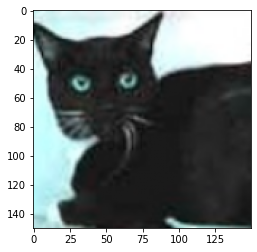

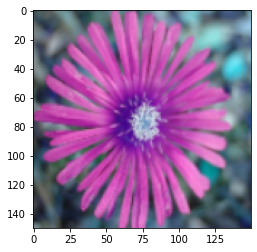

In [25]:
for i in range(0,5):
  IMG_SIZE = 150
  new_imgs = cv2.resize(X_train[i], (IMG_SIZE, IMG_SIZE))
  plt.imshow(new_imgs)
  plt.show()

**Keras Sequential model.**

In [26]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'same',activation = 'relu', input_shape = (128,128,3), name = 'Conv2D_1'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'same',activation = 'relu', name = 'Conv2D_2'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(filters = 96, kernel_size = (5,5), padding = 'same', activation = 'relu', name = 'Conv2D_3'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = 'same', activation = 'relu', name = 'Conv2D_4'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3)))
model.add(SpatialDropout2D(0.2))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.15))

model.add(Dense(8, activation = 'softmax'))

model.compile(loss = keras.losses.CategoricalCrossentropy(),
             optimizer = keras.optimizers.RMSprop(learning_rate = 0.001),
              metrics = [keras.metrics.CategoricalAccuracy()])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 42, 42, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)       

For reducing overfitting.

In [28]:
datagen = ImageDataGenerator(
    
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False    # randomly flip images
) 

datagen.fit(X_train)

In [29]:
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 100),
                                    epochs = 10, validation_data = (X_test, y_test),
                                    verbose = 1, steps_per_epoch=X_train.shape[0] // 100)

Epoch 1/10
46/46 [==============================] - 23s 498ms/step - loss: 1.4481 - categorical_accuracy: 0.5002 - val_loss: 2.3497 - val_categorical_accuracy: 0.1575
Epoch 2/10
46/46 [==============================] - 17s 364ms/step - loss: 0.9565 - categorical_accuracy: 0.6651 - val_loss: 2.4098 - val_categorical_accuracy: 0.2042
Epoch 3/10
46/46 [==============================] - 17s 360ms/step - loss: 0.8240 - categorical_accuracy: 0.7038 - val_loss: 2.9211 - val_categorical_accuracy: 0.2346
Epoch 4/10
46/46 [==============================] - 16s 355ms/step - loss: 0.7250 - categorical_accuracy: 0.7434 - val_loss: 3.3266 - val_categorical_accuracy: 0.2514
Epoch 5/10
46/46 [==============================] - 16s 355ms/step - loss: 0.6783 - categorical_accuracy: 0.7601 - val_loss: 2.9118 - val_categorical_accuracy: 0.3185
Epoch 6/10
46/46 [==============================] - 16s 355ms/step - loss: 0.6190 - categorical_accuracy: 0.7896 - val_loss: 1.9112 - val_categorical_accuracy: 0.489

Evaluation of the model on testing data.

In [30]:
model_eval = model.evaluate(X_test, y_test)

print("Loss = ", model_eval[0])
print("Test accuracy = ", model_eval[1]*100)

2502/2502 [==============================] - 2s 615us/step
Loss =  0.47428487978583805
Test accuracy =  82.69384503364563


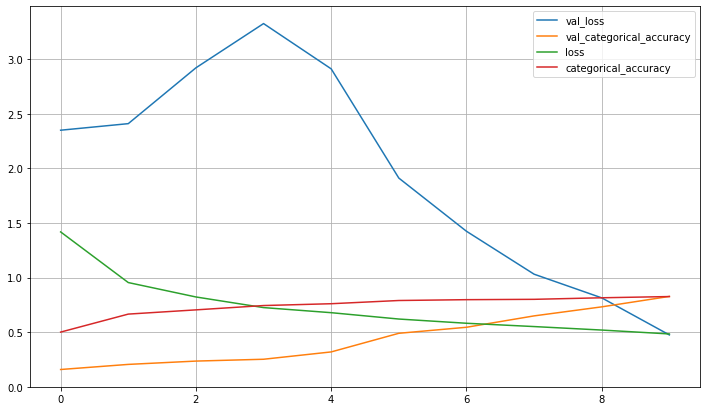

In [31]:
pd.DataFrame(model_history.history).plot(figsize = (12,7))
plt.gca()
plt.grid(True)
plt.show()

Categorical accuracy graph, to determine the accuracy.

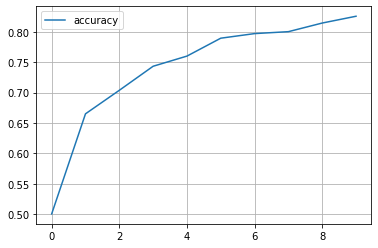

In [32]:
accuracy = model_history.history['categorical_accuracy']
plt.plot(range(len(accuracy)), accuracy, label = 'accuracy')
plt.legend()
plt.grid(True)

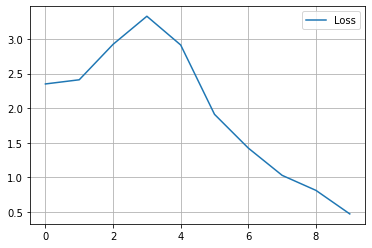

In [38]:
Loss = model_history.history['val_loss']
plt.plot(range(len(Loss)), Loss, label = 'Loss')
plt.legend()
plt.grid(True)

Prediction of X_test using the model defined above.

In [34]:
y_predict = model.predict_classes(X_test)
y_predict

array([7, 4, 6, ..., 4, 0, 6])

Argmax() function is used return the max value in an array.

In [35]:
y_test = y_test.argmax(1)
y_test

array([7, 4, 6, ..., 4, 0, 6])

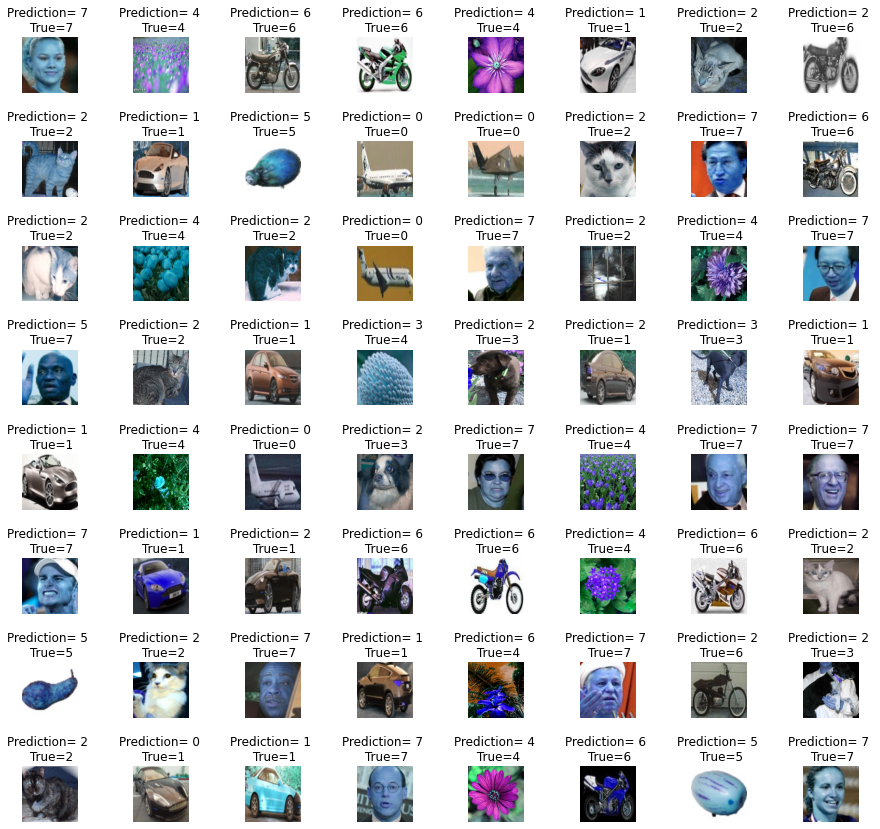

In [36]:
L = 8
W = 8
fig,axes = plt.subplots(L,W,figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction= {} \n True={}'.format(y_predict[i], y_test[i]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)